"uproot (originally μproot, for "micro-Python ROOT") is a reader and a writer of the ROOT file format using only Python and Numpy. 
- Unlike the standard C++ ROOT implementation, uproot is only an I/O library, primarily intended to stream data into machine learning libraries in Python. 
- It uses Numpy to cast blocks of data from the ROOT file as Numpy arrays. ..."

https://github.com/scikit-hep/uproot#introduction

In [2]:
import uproot

In [98]:
#uproot.open returns a ROOTDirectory, 
file = uproot.open("MonoZprime_Mx10_Mv1000-0000.root")


In [4]:
file

<ROOTDirectory b'run_mc_80X-MonoZprime_Mx10_Mv1000_MINIAOD-0000.root' at 0x00010aca7c18>

In [5]:
file.keys()

[b'ggNtuplizer;1']

In [ ]:
# which behaves like a Python dict; it has keys(), values()
file["ggNtuplizer"].keys()

In [7]:
file.compression

<Compression 'zlib' 1>

In [100]:
#and key-value access with square brackets.
file["ggNtuplizer"].values()

[<TTree b'EventTree' at 0x000112cb03c8>,
 <b'TH1F' b'hEvents' 0x0001131e8f98>,
 <b'TH1F' b'hPU' 0x0001131ef278>,
 <b'TH1F' b'hPUTrue' 0x0001131ef548>,
 <b'TH1F' b'hGenWeight' 0x0001131ef818>,
 <b'TH1F' b'hSumGenWeight' 0x0001131efae8>]

**TTrees?**
- TTrees are special objects in ROOT files: 
- They contain most of the physics data. 

In [102]:
#We care about the EventTree which has been prepared using a full C++ based "Ntuplizer"
#https://github.com/uhussain/ggAnalysis/blob/master/ggNtuplizer/plugins/ggNtuplizer_jets.cc#L177

#Complex set of C++ code, basically gets our phsysics data in a suitable format for analysis!
EventTree = dict(file.allitems(filterclass=lambda cls: issubclass(cls, uproot.tree.TTreeMethods)))

In [103]:
EventTree

{b'ggNtuplizer/EventTree;1': <TTree b'EventTree' at 0x0001131fc128>}

In [108]:
#the easiest way to browse a TTree is by calling 
#its show() method, which prints the branches and their interpretations as arrays.

#For this demo, we will only focus on one important "distinguishing feature" but there is a lot more physics 
#information available!
events = EventTree[b'ggNtuplizer/EventTree;1']
events.show()

run                        (no streamer)              asdtype('>i4')
event                      (no streamer)              asdtype('>i8')
lumis                      (no streamer)              asdtype('>i4')
isData                     (no streamer)              asdtype('bool')
nVtx                       (no streamer)              asdtype('>i4')
nGoodVtx                   (no streamer)              asdtype('>i4')
nTrksPV                    (no streamer)              asdtype('>i4')
isPVGood                   (no streamer)              asdtype('bool')
vtx                        (no streamer)              asdtype('>f4')
vty                        (no streamer)              asdtype('>f4')
vtz                        (no streamer)              asdtype('>f4')
rho                        (no streamer)              asdtype('>f4')
rhoCentral                 (no streamer)              asdtype('>f4')
HLTEleMuX                  (no streamer)              asdtype('>u8')
HLTPho                     (no s

In [12]:
events.name, events.title, events.numentries

(b'EventTree', b'Event data (tag V08_00_26_06)', 500)

In [26]:
jetetaWidth = events.array("jetetaWidth")
jetetaWidth, len(jetetaWidth)

(<JaggedArray [[0.02839153110491577 0.12647001606871283] [0.04435377465183632 0.09689661339296855 0.07412286023381369 0.10217255835725403] [0.03807543641226724] ... [0.034202589046074754 0.06386222656449118 0.1555554350814089 0.15723813912916004] [0.04267339766540858 0.17470932580742443] [0.034037611388811 0.14763384706903548 0.186483365760508 ... 0.20881514561741718 0.18050058883974143 0.13833364098757314]] at 0x00010bd38550>,
 500)

**Gosh, what is a "JaggedArray" you ask?**

In physics data, very common to have an arbitrary number of values per event than a fixed number of values per event. For instance,
- Some events will not have a "good quality" Jet 

Unlike fixed-width arrays and a fixed number of fields per element, Numpy has no analogue for this type. For this, uproot fills a new JaggedArray data structure

In [111]:
#good events are those that have a "Good Quality Jet"
goodEvents = (jetetaWidth[jetetaWidth.counts>1,0])
print(len(goodEvents))

380


In [112]:
jetPt = events.array("jetPt")
jetPt,len(jetPt)

(<JaggedArray [[312.14008 49.32167] [257.03836 117.6442 49.022663 42.8722] [282.67545] ... [276.55554 97.271706 43.804375 20.490173] [411.52444 23.596752] [285.71173 61.455017 32.396637 ... 21.566664 21.098133 21.075525]] at 0x0001134ca828>,
 500)

In [113]:
import matplotlib.pyplot as plt


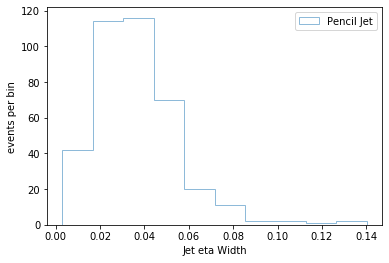

In [114]:
plt.xlabel("Jet eta Width");
plt.ylabel("events per bin");
plt.hist(goodEvents,histtype='step',alpha=0.5,label='Pencil Jet')
plt.legend()

In [118]:
#Lazy array of many signal files!
signal = uproot.lazyarray( ["MonoZprime_Mx10_Mv1000-%s.root" % x
        for x in ["0030","0040","0050","0060","0070","0080","0090"]],
    # TTree name in each file
    "ggNtuplizer/EventTree;1",
    # branch(s) in each file for lazyarray(s)
    "jetetaWidth")
len(signal)

3500

In [119]:
#Signal events with a jet candidate with momentum (pt > 20 GeV)
#https://github.com/uhussain/ggAnalysis/blob/master/ggNtuplizer/plugins/ggNtuplizer_jets.cc#L556
GoodSignal = (signal[signal.counts>1,0])
len(GoodSignal)

2643

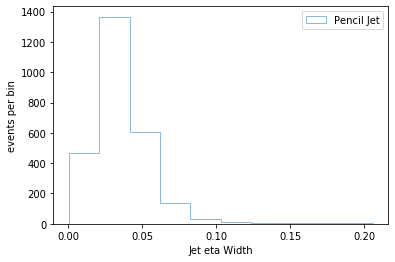

In [120]:
#Plotting the same variable as above but with higher statistics
plt.xlabel("Jet eta Width");
plt.ylabel("events per bin");
plt.hist(GoodSignal,histtype='step',alpha=0.5,label='Pencil Jet')
plt.legend()